**Necessary Imports**

In [1]:
###
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob
import shutil
import pathlib
import random

#model selection
from sklearn.model_selection import train_test_split

#data augumentation
import  cv2
import imgaug
import imageio
from imgaug import augmenters as iaa

##
import keras.utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from keras.layers import Dense, GlobalMaxPool2D, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.activations import selu

In [2]:
###
import tensorflow as tf
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob
import shutil
import pathlib
import random

from keras.applications import ResNet50
#model selection
from sklearn.model_selection import train_test_split

#data augumentation
import  cv2
import imgaug
import imageio
from imgaug import augmenters as iaa

##
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.applications import VGG16
from keras.layers import Dense, GlobalMaxPool2D, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [3]:
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.12.0


**Drive Mount**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
save_path = '/content/drive/MyDrive/'
save_path1 = '/content/drive/MyDrive/'

In [6]:
!unzip /content/drive/MyDrive/NewDataset.zip

Archive:  /content/drive/MyDrive/NewDataset.zip
  inflating: NewData/TestLabels.npy  
  inflating: NewData/ValLabels.npy   
  inflating: NewData/TrainLabels.npy  
  inflating: NewData/ValData.npy     
  inflating: NewData/TestData.npy    
  inflating: NewData/TrainData.npy   


In [7]:
#Run from here
import os
x_train = []
y_train = []
x_train = np.load("/content/NewData/TrainData.npy")
y_train = np.load("/content/NewData/TrainLabels.npy")

x_val = []
y_val = []
x_val = np.load("/content/NewData/ValData.npy")
y_val = np.load("/content/NewData/ValLabels.npy")

x_test = []
y_test = []
x_test = np.load("/content/NewData/TestData.npy")
y_test = np.load("/content/NewData/TestLabels.npy")

print(f"x_train shape: {x_train .shape} - y_train shape: {y_train .shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test .shape}")

x_train shape: (18123, 110, 110, 3) - y_train shape: (18123,)
x_val shape: (648, 110, 110, 3) - y_val shape: (648,)
x_test shape: (812, 110, 110, 3) - y_test shape: (812,)


**Training Models**

# **Fine Tunning**

In [8]:
base_model=keras.applications.mobilenet_v2.MobileNetV2(input_shape=(110,110,3),weights='imagenet',include_top=False)
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)



9406464/9406464 [==============================] - 1s 0us/step
0 input_1
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 

In [9]:
for layer in base_model.layers[:100]:
        layer.trainable = False
for layer in base_model.layers[100:]:
        layer.trainable = True

In [11]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

In [12]:
 model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_mobilenet_ft.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=1e-5)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [14]:
print(y_train.shape)

(18123,)


In [15]:
import numpy as np
from tensorflow.keras.utils import to_categorical


y_train_one_hot = to_categorical(y_train, num_classes=5)
y_val_one_hot = to_categorical(y_val, num_classes=5)


In [16]:
 model = Model(inputs=base_model.input, outputs=predictions)

In [18]:


epochs = 10
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
trainMobileNetV2FT = model.fit(x=x_train, y=y_train_one_hot, validation_data=(x_val, y_val_one_hot), epochs=50,callbacks=callbacks)

Epoch 1/50
567/567 [==============================] - ETA: 0s - loss: 0.9537 - accuracy: 0.6372
Epoch 1: val_accuracy improved from -inf to 0.39969, saving model to saved_models/model_mobilenet_ft.hdf5
567/567 [==============================] - 32s 32ms/step - loss: 0.9537 - accuracy: 0.6372 - val_loss: 4.8884 - val_accuracy: 0.3997 - lr: 0.0010
Epoch 2/50
567/567 [==============================] - ETA: 0s - loss: 0.7160 - accuracy: 0.7321
Epoch 2: val_accuracy improved from 0.39969 to 0.46451, saving model to saved_models/model_mobilenet_ft.hdf5
567/567 [==============================] - 14s 26ms/step - loss: 0.7160 - accuracy: 0.7321 - val_loss: 3.3096 - val_accuracy: 0.4645 - lr: 0.0010
Epoch 3/50
566/567 [============================>.] - ETA: 0s - loss: 0.6125 - accuracy: 0.7702
Epoch 3: val_accuracy improved from 0.46451 to 0.70062, saving model to saved_models/model_mobilenet_ft.hdf5
567/567 [==============================] - 16s 27ms/step - loss: 0.6124 - accuracy: 0.7702 - val

Saving Model in GDrive

In [20]:
 model.save(save_path + 'model_mobilenet_ft.hdf5')



In [21]:
y_test_one_hot = to_categorical(y_test, num_classes=5)
accuracy =  model.evaluate(x_test, y_test_one_hot)[1]

26/26 [==============================] - 1s 37ms/step - loss: 0.3001 - accuracy: 0.9655


Evaluating Model

In [22]:
from tensorflow.keras.models import load_model
FT_mobilenet= load_model(save_path + 'model_mobilenet_ft.hdf5')


26/26 [==============================] - 1s 13ms/step


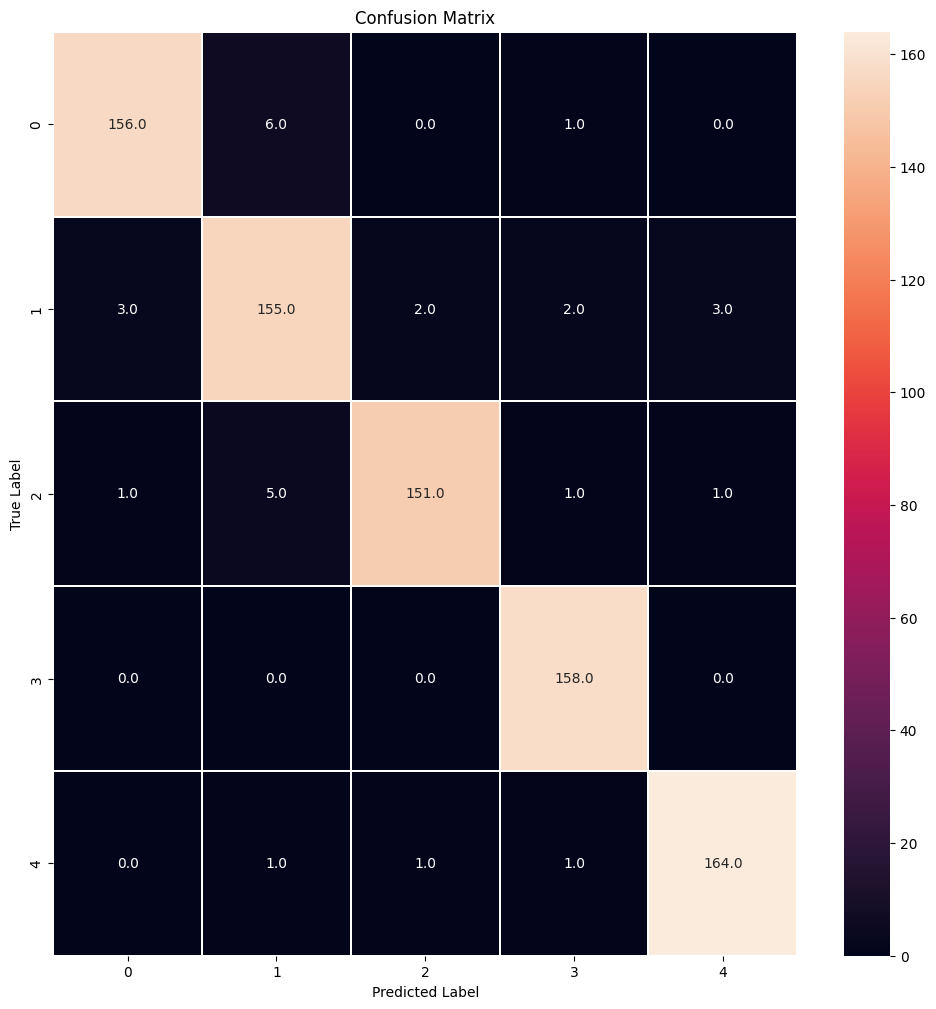

In [23]:
cancer_classes = np.unique(y_test)
pred = FT_mobilenet.predict(x_test)
y_pred = np.argmax(pred, axis=1)

confusion_mtx = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt='.1f', ax=ax, cmap="rocket")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.set_xticklabels(cancer_classes)
ax.set_yticklabels(cancer_classes)
plt.title("Confusion Matrix")
plt.show()

In [24]:
report1 = classification_report(y_test, y_pred, target_names=cancer_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
0,0.975000,0.957055,0.965944,163.000000
1,0.928144,0.939394,0.933735,165.000000
2,0.980519,0.949686,0.964856,159.000000
3,0.969325,1.000000,0.984424,158.000000
4,0.976190,0.982036,0.979104,167.000000
accuracy,0.965517,0.965517,0.965517,0.965517
macro avg,0.965836,0.965634,0.965613,812.000000
weighted avg,0.965700,0.965517,0.965489,812.000000


# Cost Sensitive

In [25]:
from sklearn.utils import class_weight

class_weights = dict(zip(np.unique(y_test), class_weight.compute_class_weight('balanced', classes = np.unique(y_test),
                                        y = y_test))) 

class_weights

{0: 0.996319018404908,
 1: 0.9842424242424243,
 2: 1.0213836477987421,
 3: 1.0278481012658227,
 4: 0.9724550898203593}

In [26]:
modelCS_mobilenet=load_model(save_path + 'model_mobilenet_ft.hdf5')
epochs = 50
opt = Adam(learning_rate=1e-3)
modelCS_mobilenet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
checkpointer = ModelCheckpoint(filepath='saved_models/modelCS_mobilenet_CS.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=1e-5)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [34]:
modelCS_mobilenet.fit(x=x_train, y=y_train_one_hot, validation_data=(x_val, y_val_one_hot), epochs=50, class_weight=class_weights,callbacks=callbacks)

Epoch 1/50
565/567 [============================>.] - ETA: 0s - loss: 0.0192 - accuracy: 0.9930
Epoch 1: val_accuracy did not improve from 0.96296
567/567 [==============================] - 16s 28ms/step - loss: 0.0193 - accuracy: 0.9929 - val_loss: 0.2305 - val_accuracy: 0.9552 - lr: 4.0000e-05
Epoch 2/50
566/567 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9937
Epoch 2: val_accuracy did not improve from 0.96296
567/567 [==============================] - 14s 25ms/step - loss: 0.0171 - accuracy: 0.9937 - val_loss: 0.2233 - val_accuracy: 0.9599 - lr: 4.0000e-05
Epoch 3/50
567/567 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9944
Epoch 3: val_accuracy did not improve from 0.96296
567/567 [==============================] - 14s 25ms/step - loss: 0.0154 - accuracy: 0.9944 - val_loss: 0.2574 - val_accuracy: 0.9568 - lr: 4.0000e-05
Epoch 4/50
567/567 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9953
Epoch 4: val_

In [29]:
modelCS_mobilenet.save(save_path + 'modelCS_mobilenet_CS.hdf5')
#modelCS_VGG16.save_weights(save_path1 + "Weights_FTCS_VGG16.h5")


In [30]:
y_test_one_hot = to_categorical(y_test, num_classes=5)
accuracy = modelCS_mobilenet.evaluate(x_test, y_test_one_hot)[1]

26/26 [==============================] - 0s 16ms/step - loss: 0.3052 - accuracy: 0.9557


In [31]:
CS_mobilenet= load_model(save_path + 'modelCS_mobilenet_CS.hdf5')

26/26 [==============================] - 2s 17ms/step


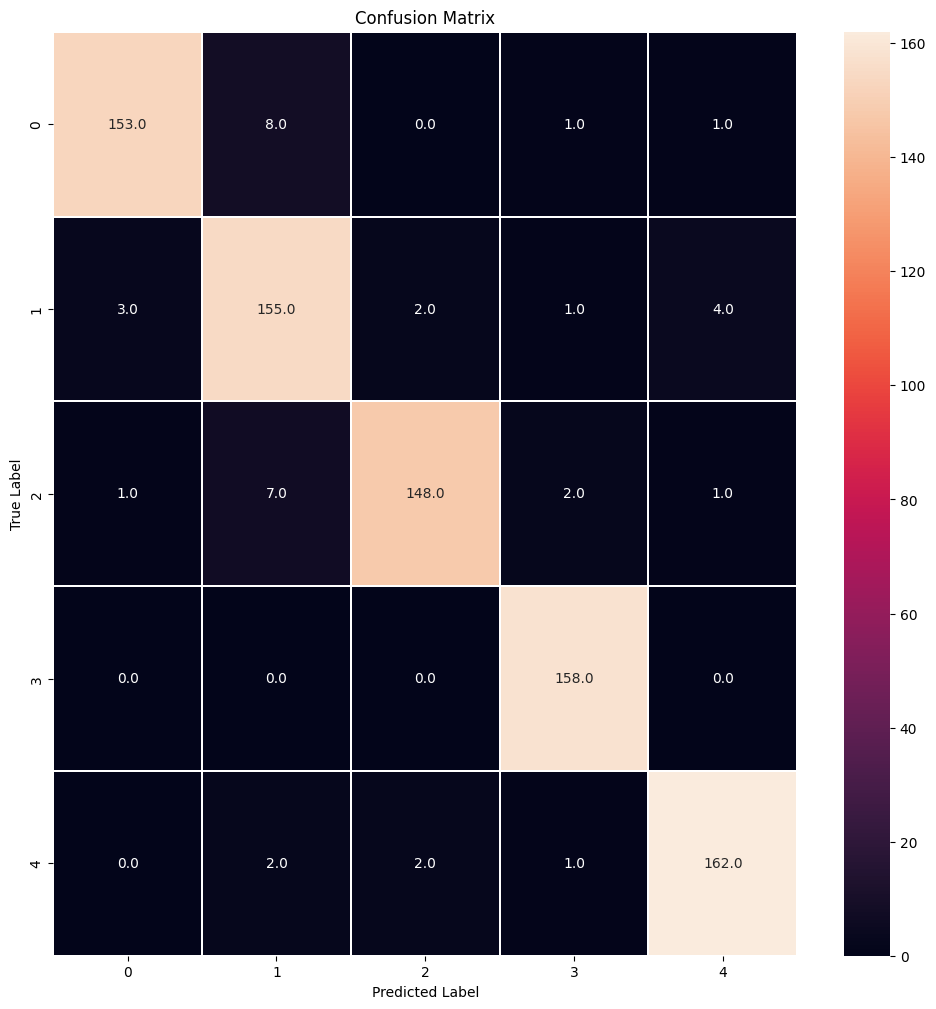

In [32]:
cancer_classes = np.unique(y_test)
pred = CS_mobilenet.predict(x_test)
y_pred = np.argmax(pred, axis=1)

confusion_mtx = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt='.1f', ax=ax, cmap="rocket")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.set_xticklabels(cancer_classes)
ax.set_yticklabels(cancer_classes)
plt.title("Confusion Matrix")
plt.show()


In [33]:
report12 = classification_report(y_test, y_pred, target_names=cancer_classes, output_dict=True)
df12 = pd.DataFrame(report12).transpose()
df12

,precision,recall,f1-score,support
0,0.974522,0.938650,0.956250,163.000000
1,0.901163,0.939394,0.919881,165.000000
2,0.973684,0.930818,0.951768,159.000000
3,0.969325,1.000000,0.984424,158.000000
4,0.964286,0.970060,0.967164,167.000000
accuracy,0.955665,0.955665,0.955665,0.955665
macro avg,0.956596,0.955784,0.955898,812.000000
weighted avg,0.956335,0.955665,0.955709,812.000000
